# Created September 14, 2020

## Author of this version: Jacob Carrasco (Update for new versions)

## *Before making updates please create a new version number and file the old version in the Google Drive archive ("Austin hotel permit data_XX")

This short notebook is intended to provide some motivation for the entry-exit patterns seen in the hotel industry. Other forms of real estate may also be interesting, but initial exploration is going to be restricted to lodging.

## --- Initial questions that need to be tested include ---

* 1) Who are the key market players (developers)? Who seems to be developing the most projects? Do some developers seem to file for permits early in construction boom cycles? Are others filing for permits later in the cycles?

* 2) What firms are some of the initial entrants?

* 3) Do firm entry decisions seem to increase the probability of future entry? Does entry seem to be correlated with past entry?


## --- Next steps, in order of priority ---
* A) Finalize cleaning and identification of hotels from universe of all construction data
    * While doing this first step, it is important to keep a list of outstanding questions about the data that can be discussed with someone in the Austin government 
* B) Test initial questions graphically first and by exploring specific projects (limiting this to 1-2 hours)
* C) Approach questions more formally with regression design, this may require thinking about further controls for hotel entry. An aggregate measure of interest rates has already been included. Other controls might include:
    * Land, labor, materials or capital construction costs (not sure how much cross time variation there is here for just one city)
    * Macroeconomic measures of market trends such as unemployment, local wage growth, GDP growth (Dallas Fed publishes some regional data for Texas)
    * Would want to also include seasonality or other time dummies but these don't need to be collected. May want to also consider "micro-geography" dummies at the zip code or neighborhood level
    
* D) It is unlikely that time-variation alone is sufficient for this study; once Austin has been explored, need to think about expanding the sample size to include more cities

## --- Current sources ---
   * Permit data: https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu
   * Interest rates: https://fred.stlouisfed.org/series/MPRIME
   * Dallas Fed Economic Data (Not yet collected): https://www.dallasfed.org/research/econdata

# 0. Preamble (load library and data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Change format of aggregate statistic reports
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# Load my compressed Austin construction permit data
df = pd.read_csv("AUS_permits.csv", low_memory=False) # low_memory avoids a warning message

# Load interest rates data
interest = pd.read_csv("Bank Prime Loan Rate.csv")

print(df.shape)
df.head(10)

(2000985, 68)


,Permit Type,Permit Type Desc,Permit Num,Permit Class Mapped,Permit Class,Work Class,Condominium,Project Name,Description,TCAD ID,...,Contractor Zip,Applicant Full Name,Applicant Organization,Applicant Phone,Applicant Address 1,Applicant Address 2,Applicant City,Applicant Zip,Certificate Of Occupancy,Total Lot SQFT
0,DS,Driveway / Sidewalks,2003-048196 DS,Commercial,NaN,NaN,NaN,SUEP Permit #031204249,CONSTRUCTING NEW APPROACH 433Z,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MP,Mechanical Permit,1982-018290 MP,Commercial,NaN,New,No,12132 Burnet Road A 00000,H T,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
2,MP,Mechanical Permit,1980-007190 MP,Commercial,Commercial,Remodel,No,900 12 Street West A 00000,Sign,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
3,PP,Plumbing Permit,1982-019431 PP,Commercial,NaN,NaN,No,11601 Quarter Horse Trail C 00000,Residence,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
4,EP,Electrical Permit,1984-020758 EP,Residential,Residential,Remodel,No,14580 Great Eagle Trail L 00000,Res,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
5,EP,Electrical Permit,1986-012617 EP,Commercial,Commercial,Remodel,No,1809 Brandt Road A .00000,HT Loop Oh,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
6,EP,Electrical Permit,1982-016692 EP,Commercial,NaN,New,No,7122 Mo-Pac Circle A 00000,Comm,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
7,BP,Building Permit,1981-006839 BP,Commercial,NaN,NaN,No,128 Crestview Drive L 00000,New Residence,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
8,BP,Building Permit,2002-001412 BP,Commercial,Commercial,Remodel,No,15243 Calaveras Dr,Install Plbg Equipment Only,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
9,DS,Driveway / Sidewalks,2007-104828 DS,Residential,Res. Driveway & Sidewalk,NaN,NaN,NaN,XXXXX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Initial cleaning and exploration

It is okay to delete some of these as long as a new version has been created

In [3]:
# There may be columns outstanding that still need to be reformatted

def comma_replacer(var):
    df.loc[:,var] = df[var].replace(',', "",regex=True).astype(float)
    
def datetime_formatter(date_var):
    df.loc[:, date_var] = df[date_var].astype('Datetime64')
    
# Data before 1990 seems a bit strange but I'm retaining it for now. It requires further investigation
# 2020 removed due to potential Covid-19 issues
# Note the use of my custom functions below! 

df = df[(df['Fiscal Year Issued'] < 2020)]

# Remove commas and convert housing units into float var
comma_replacer('Housing Units')
comma_replacer('Total New Add SQFT')
comma_replacer('Number Of Floors')
comma_replacer("Total Job Valuation")

# Print descriptive statistics of one of the variables above to make sure the code worked
print(df['Total New Add SQFT'].describe())

# Datetime formatting
datetime_formatter('Issued Date')
datetime_formatter('Applied Date')
datetime_formatter('Status Date')
datetime_formatter('Expires Date')
datetime_formatter('Completed Date')

# Extract month-year
df.loc[:, "issue_MOYR"] = df['Issued Date'].dt.to_period('M')

# Make all descriptions lower case
df.loc[:, 'Description'] = df['Description'].str.lower()
df.loc[:, 'Project Name'] = df['Project Name'].str.lower()
df.loc[:, 'Original Address 1'] = df['Original Address 1'].str.lower()

count    297132.00000
mean       5340.13228
std       27465.30508
min        -496.00000
25%         800.00000
50%        2155.00000
75%        3135.00000
max     2150640.00000
Name: Total New Add SQFT, dtype: float64


# 2. Initial graphics

In [ ]:
# Graph to see aggregate permit counts

plt.plot(df.groupby('Calendar Year Issued')['Permit Type'].count())
plt.title("Number of Austin permit filings by calendar year issued")
plt.show()

In [ ]:
df.groupby('Calendar Year Issued')['Permit Type'].count()

In [ ]:
# See Permit types by work class

df.groupby('Work Class')['Permit Type'].count().sort_values()

In [ ]:
# Graph work class counts for a select group of them. Graph in logs to allow comparison in growth patterns across
# work classes with very different scales

for i in ['New', 'Shell', 'Remodel', 'Addition and Remodel', 'Addition', 'Modification', 'Demolition', 'Repair']:

    plt.plot(np.log(df[df['Work Class'] == i].groupby('Calendar Year Issued')['Permit Type'].count()[5:]), label=i)

plt.title("Log(Count) by select Work Classes")    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# Counts by Permit class (50 largest)
df.groupby(['Permit Class'])['Permit Type'].count().sort_values()[-50:]

In [ ]:
for i in ['New', 'Shell', 'Remodel', 'Addition and Remodel', 'Addition', 'Modification', 'Demolition', 'Repair']:

    plt.plot(np.log(df[df['Work Class'] == i].groupby('Calendar Year Issued')['Total Job Valuation'].mean()[5:]), label=i)

plt.title("Log(Total Job Valuation) by select Work Classes")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# ------------------------------------------------

for i in ['C-1000 Commercial Remodel', 'Commercial', 'C- 329 Com Structures Other Than Bldg',
'C- 105 Five or More Family Bldgs', 'C- 328 Commercial Other Nonresident Bldg',
'C- 213 Hotels, Motels, & Tourist Cabins']:

    plt.plot(df[df['Permit Class'] == i].groupby('Calendar Year Issued')['Total Job Valuation'].mean()[5:], label=i)

plt.title("Log(Total Job Valuation) by select Work Classes")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# ------------------------------------------------

for i in ['Commercial']:

    plt.plot(df[df['Permit Class'] == i].groupby('Calendar Year Issued')['Total Job Valuation'].mean()[5:], label=i)

plt.title("Total Job Valuation by select Work Classes")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# ------------------------------------------------

for i in ['New', 'Shell', 'Remodel', 'Addition and Remodel', 'Addition', 'Modification', 'Demolition', 'Repair']:

    plt.plot(np.log(df[df['Work Class'] == i].groupby('Calendar Year Issued')['Total Job Valuation'].mean()[5:]), label=i)

plt.title("Log(Total Job Valuation) by select Work Classes")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# ------------------------------------------------

for i in df['Permit Type Desc'].unique():

    plt.plot(df[df['Permit Type Desc'] == i].groupby('Calendar Year Issued')['Permit Type'].count()[5:], label=i)
    
plt.legend()
plt.show()


In [ ]:
# Just trying to get a sense of "what is a shell"?

df[((df['Description'].str.contains(['hotel')) | (df['Description'].str.contains('motel'))) & 
  (df['Work Class'] == "Shell")]['Description'].values

In [ ]:
# Ranking work classes by the total job valuation

df.groupby(['Work Class'])['Total Job Valuation'].mean().sort_values(ascending=False)

In [ ]:
df[df['Project Name'].str.contains("101 red river", na=False)][['Permit Type', 'Permit Class', 'Work Class', 'Description', 'Total Job Valuation']].sort_values(by='Total Job Valuation', ascending=False)

In [ ]:
# Bar graphs to see permit trends in the hotel industry. This code is quite inefficient at the moment.

overall_hotel = df[df['Permit Class'] == "C- 213 Hotels, Motels, & Tourist Cabins"].groupby('Calendar Year Issued')['Permit Type'].count()

new_building_permit_hotel = df[(df['Total Job Valuation'] > 1e6) & ((df['Work Class'] == "New") | (df['Work Class'] == "Shell") )   & (df['Permit Class Mapped'] == "Commercial") &
    (df['Permit Class'] == "C- 213 Hotels, Motels, & Tourist Cabins")].groupby('Calendar Year Issued')['Permit Type'].count()


plt.bar(overall_hotel.index,
        overall_hotel.values, label="Overall")

plt.bar(new_building_permit_hotel.index,
       new_building_permit_hotel.values, label='New projects with val > 1m')

plt.title("C-213 Hotels, Motels & Tourist Cabins - permits")

plt.legend()
plt.show()

units_hots = df[(df['Housing Units'] > 200) & ((df['Work Class'] == "New") | (df['Work Class'] == "Shell") )   & (df['Permit Class Mapped'] == "Commercial") &
    (df['Permit Class'] == "C- 213 Hotels, Motels, & Tourist Cabins")].groupby('Calendar Year Issued')['Permit Type'].count()

high_val = df[(df['Total Job Valuation'] > 50e6) & ((df['Work Class'] == "New") | (df['Work Class'] == "Shell") )   & (df['Permit Class Mapped'] == "Commercial") &
    (df['Permit Class'] == "C- 213 Hotels, Motels, & Tourist Cabins")].groupby('Calendar Year Issued')['Permit Type'].count()

tall_hots = df[(df['Number Of Floors'] > 20) & ((df['Work Class'] == "New") | (df['Work Class'] == "Shell") )   & (df['Permit Class Mapped'] == "Commercial") &
    (df['Permit Class'] == "C- 213 Hotels, Motels, & Tourist Cabins")].groupby('Calendar Year Issued')['Permit Type'].count()

# ------------------------------------------------------------------------------

plt.bar(overall_hotel.index,
        overall_hotel.values, label="Overall")

plt.bar(units_hots.index,
       units_hots.values, label="Projects with more than 200 units")

plt.legend()
plt.show()

plt.bar(overall_hotel.index,
        overall_hotel.values, label="Overall")

plt.bar(high_val.index,
       high_val.values, label="Projects exceeding 50m")

plt.legend()
plt.show()

plt.bar(overall_hotel.index,
        overall_hotel.values, label="Overall")

plt.bar(tall_hots.index,
       tall_hots.values, label="Projects exceeding 10 floors")

plt.legend()
plt.show()

In [ ]:
df[(df['Project Name'].str.contains("2120 lamar boulevard",na=False)) & (df['Permit Type'] == "BP")][['issue_MOYR', 'Description', 'Total Job Valuation', 'Total New Add SQFT', 'Housing Units']]

In [ ]:
# Conditions to identify new construction of hotels (remodelling or conversion may also be interesting)

# Conditions to filter out new construction
desc_inds = ['hotel', 'motel']

# Conditions to remove, I don't want remodelling, replacement (maybe should keep replace?) or demolishing. 
desc_remove = ["remodel", "replace", "demolish"]

my_conds = ((df['Permit Type'] == "BP") & (df["Permit Class Mapped"] == "Commercial") & 
    (df['Work Class'] == "New") & (~(df['Total New Add SQFT'].isna()) | ~(df['Number Of Floors'].isna()) | ~(df['Housing Units'].isna()))
            & (df['Total Job Valuation'] >= 1e6) & (df['Description'].str.contains('|'.join(desc_inds), na=False))
           & (~df['Description'].str.contains("|".join(desc_remove), na=False))) 

cond_df = df[my_conds][['issue_MOYR', 'Permit Class', 'Issued Date', 'Permit Type', 'Work Class', 'Project Name', 'Description','Total New Add SQFT', 
                       'Number Of Floors', 'Housing Units', 'Total Job Valuation']]

print(len(cond_df))

In [ ]:
cond_df[cond_df["Number Of Floors"].isna()]

# 3. Identifying individual projects

The function below doesn't work particularly well yet.

In [ ]:
# The function below allows me to enter key terms from an address and a number in an attempt to locate projects

def project_finder(key_terms): # Key terms should be a list object

    return df[((df['Original Address 1'].str.contains('&'.join(key_terms), na=False))) | 
    (df['Project Name'].str.contains('&'.join(key_terms), na=False) ) & (df['Permit Type'] == "BP")][['Project Name', 'Original Address 1', 'Description']]    

In [ ]:
df[df['Project Name'].str.contains("110 e 2nd", na=False)][['Project Name', 'Original Address 1']].values

In [ ]:
# This function finds specific projects

project_finder(['110 e 2nd st'])

In [ ]:
# Nice example hotel from the data. Try to keep this as an illustration

df[(df['Project Name'] == "701 e stassney ln bldg l")][['Project Name', 'Issued Date', 'Permit Type', "Permit Type Desc", 
                                                     'Permit Num', "Permit Class Mapped",
                                                     'Permit Class', 'Work Class', 
                                                     'TCAD ID', 'Description', 'Contractor Trade']].sort_values(by='Issued Date')

# 4. Entry/exit patterns

In [ ]:
month_dates_grid = pd.DataFrame(pd.date_range(start='1980-01-01', end='2020-01-01', freq='MS'))
month_dates_grid.columns = ['mo_yr']

In [ ]:
# Create a dataframe that counts entry and exit of hotels

dates = cond_df.groupby('issue_MOYR')['Issued Date'].count().index
counts = cond_df.groupby('issue_MOYR')['Issued Date'].count().values

permits_df = pd.DataFrame([dates, counts]).T
permits_df.columns = ['mo_yr', 'counts']

In [ ]:
permits_df['mo_yr'] = permits_df['mo_yr'].astype(str).astype('Datetime64')

In [ ]:
hot_activity = month_dates_grid.merge(permits_df[['mo_yr', 'counts']], on='mo_yr', how='left')

In [ ]:
hot_activity = hot_activity.fillna(0)

In [ ]:
hot_activity.loc[:, "MA6"] = hot_activity['counts'].rolling(window=6).mean()
hot_activity.loc[:, "MA12"] = hot_activity['counts'].rolling(window=12).mean()
hot_activity.loc[:, "MA18"] = hot_activity['counts'].rolling(window=18).mean()

In [ ]:
plt.plot(hot_activity.mo_yr, hot_activity.counts, color='green', label='Monthly permits')
# plt.plot(hot_activity.mo_yr, hot_activity.MA6, label='6-month MA')
plt.plot(hot_activity.mo_yr, hot_activity.MA12, color='black', linewidth=1.5, label='12-month MA')

plt.title("Monthly Austin permit counts and 12-month moving average")
plt.legend()
plt.show()

# 5. Interest rates and activity

In [ ]:
interest.loc[:, "DATE"] = interest.DATE.astype('Datetime64')

In [ ]:
hot_act = hot_activity.merge(interest[['DATE', 'MPRIME']], left_on='mo_yr', right_on='DATE', how='left')

In [ ]:
plt.plot(hot_act.mo_yr, hot_act.MA12)
plt.plot(hot_act.mo_yr, hot_act.MPRIME)

plt.show()

In [ ]:
# Pearson is the standard correlation coefficient 

hot_act.corr(method='pearson')

In [ ]:
plt.scatter(hot_act.MPRIME, hot_act.MA12, label='MA12')


plt.legend()
plt.show()

In [ ]:
def two_axis_graph(df):

    dates1 = df['mo_yr']
    dates2 = df['mo_yr']

    data1 = df['MA12']
    data2 = df['MPRIME']

    fig, ax1 = plt.subplots()
    plt.xticks(rotation="vertical")

    price_color = 'tab:red'
    ax1.set_ylabel('12-month moving average hotel entry', color='red')
    lns1 = ax1.plot(dates1, data1, color=price_color, label="MA-hots")
    ax1.tick_params(axis='y', labelcolor='red')
    # ax1.set_ylim(0, 500)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    act_color = 'tab:green'
    ax2.set_ylabel('Monthly Bank Prime Loan Rate (%)', color='green')  # we already handled the x-label with ax1
    lns2 = ax2.plot(dates2, data2, color=act_color, label="Interest")
    ax2.tick_params(axis='y', labelcolor='green')


    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [ ]:
two_axis_graph(hot_act)

# Jacob Work

In [4]:
df[((df['Description'].str.contains('hotel')) | (df['Description'].str.contains('motel') | (df['Description'].str.contains('tourist cabin'))))]['Description'].groupby(by = df['Calendar Year Issued']).count()

Calendar Year Issued
1979      2
1980     31
1981     34
1982     76
1983     69
1984    112
1985    132
1986    120
1987     41
1988     27
1989     21
1990     21
1991     17
1992     50
1993     33
1994     66
1995     66
1996     81
1997     87
1998     84
1999     80
2000     61
2001     63
2002     47
2003     11
2004     48
2005     73
2006     83
2007    218
2008    196
2009    136
2010     70
2011    101
2012    237
2013    249
2014    414
2015    361
2016    447
2017    270
2018    331
2019    385
Name: Description, dtype: int64

In [5]:
## List of unique organizations
df['Applicant Organization'].dropna().unique

<bound method Series.unique of 3140                       Hundley's Htg & A/C Inc.
3169                      Dream Makers Construction
3172                                DOMIN RAYMOND L
3203                               Foley Properties
3232                Lennar Homes of Texas***MAIN***
                             ...                   
2000339    MGD LANTANA-Morgan Group Development LLC
2000345                          Austin Canyon Corp
2000346     Greystar Development & Construction, LP
2000349              Epoch Properties lane 111, llc
2000350                      Urban Intown Homes LLC
Name: Applicant Organization, Length: 138303, dtype: object>

In [6]:
## Create sub data frame with just 'hotel' in the desrciption
## Create a pandas series that is boolean on weather description contains hotel
df['Hotel'] = df['Description'].str.contains('hotel')
## Turn the boolean series to a dummy variable
df = pd.concat([df, pd.get_dummies(df['Hotel'].astype('category'), prefix = 'd')], axis = 1)

In [7]:
## produce data frame where df['Hotels'] = True
df2 = df[df.d_True != 0]

In [8]:
#count of applications per org
df2.groupby('Applicant Organization')['Permit Type'].count().sort_values(ascending = False)

Applicant Organization
Hunt Construction Group (Arizona)               76
DPR Construction  *MAIN**                       38
TD Industries Inc                               32
Katerra Construction LLC                        28
Hunt Construction Group Inc                     28
                                                ..
HOEGGER & ASSOCIATES                             1
Rogers-O'Brien Construction Co. LTD **MAIN**     1
Ross-DePass Buildin SVC.                         1
H.I. Austin Airport , LP                         1
3401 Hoteliers Lp                                1
Name: Permit Type, Length: 262, dtype: int64

In [9]:
top5 = ['Hunt Construction Group (Arizona)', 'DPR Construction  *MAIN**', 'TD Industries Inc', 'Katerra Construction LLC','Hunt Construction Group Inc']

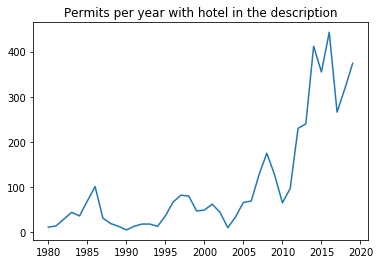

In [10]:
## Permits with hotel in the name per year
plt.plot(df2.groupby('Calendar Year Issued')['Permit Type'].count())
plt.title('Permits per year with hotel in the description')
plt.show()

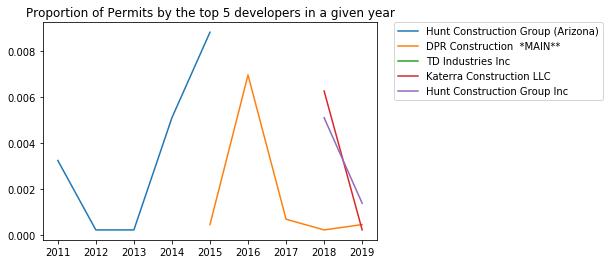

In [11]:
for i in top5:
    plt.plot((df2[df2['Applicant Organization'] == i].groupby('Calendar Year Issued')['Permit Type'].count())/len(df2), label=i)
plt.title("Proportion of Permits by the top 5 developers in a given year")    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
    

In [24]:
df2 = df2.rename(columns = {'Applicant Organization':'Applicant_Organization'})

In [76]:
#Creating t, a list that holds the years covered in the data set
#Creating a data series that represents the proportion of applications in that year for organization i
#to create the series for the company, i will reduce the data set to just entries of that company,
#then group by year and apply the count function of permits per year and store that as the y
#Then from that data, i will be able to easily use plt to show the proportion over time of the orgs
dfi = df2[df2.Applicant_Organization == top5[0]]

In [77]:
dfi.groupby('Calendar Year Issued')['Permit Type'].count()

Calendar Year Issued
2011    14
2012     1
2013     1
2014    22
2015    38
Name: Permit Type, dtype: int64

In [78]:
#list of unique calendar years in a list
t = df2['Calendar Year Issued'].unique().tolist()

In [79]:
"""
data = []
for i in t:
    count = 0
    for x in dfi['Calendar Year Issued']:
        if i == x:
            count += 1
    data.append(count)
ser = pd.Series(data, index = t)
"""

"\ndata = []\nfor i in t:\n    count = 0\n    for x in dfi['Calendar Year Issued']:\n        if i == x:\n            count += 1\n    data.append(count)\nser = pd.Series(data, index = t)\n"

In [80]:
#start with a list, for every year in t, loop through dfi to see how many times it contains that value
#add that count to the data list, same length as t
#turn that list into a series that can be used to plot
def series_org(a):
    data = []
    for i in t:
        count = 0
        for x in a['Calendar Year Issued']:
            if i == x:
                count += 1
        data.append(count)
    ser = pd.Series(data, index = t)
    return ser

No handles with labels found to put in legend.


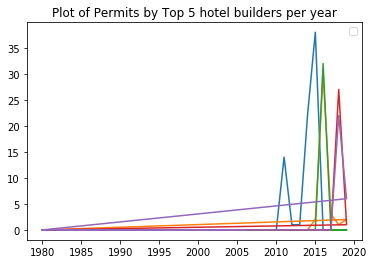

In [85]:
for i in top5:
    dfi = df2[df2.Applicant_Organization == i]
    x = series_org(dfi)
    plt.plot(x)
plt.title('Plot of Permits by Top 5 hotel builders per year')
plt.legend()
plt.show()

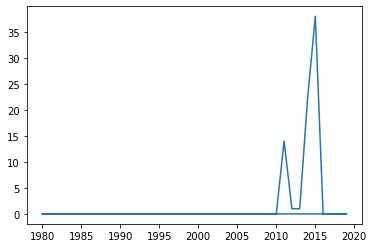

In [81]:
b = series_org(dfi)
plt.plot(b)
plt.show()

In [12]:
#Trying to plot when the top 5 build, overlayed by total permits. 
#Basically the logic is, if you see that the top 5 spike at the same time as total permits spike
#then one could say that they 'set off' the explosion and all the follow on
#might also add a line which is basically, all other developers besides the top 5
data1 = df2.groupby('Applicant Organization')
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

KeyError: ''